This script contains all analysis for behaviroal data. 

## Parse PsychoPy responses

In [1]:
import os
import glob
import re
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def extract_cq_info(data_file):
    '''
    This function reads in psychopy csv file and extracts answers and subject
    responses to the comprehension questions

    Parameters
    ----------
    data_file : string
        DESCRIPTION. The path to PsychoPy csv file.

    Returns
    -------
    answer df: dataframe
        DESCRIPTION. df contains answers and subject responses

    '''
    # read the csv file
    df = pd.read_csv(data_file)
    # locate to rows that store answers and responses
    mask = np.where(pd.isnull(df['key_resp_question.keys']) == False)[0]
    reading = df.loc[mask, 'reading']
    answers = df.loc[mask, 'Answer']
    responses = df.loc[mask, 'key_resp_question.keys']
    pages = np.arange(len(reading))
    # create the return dataframe with these two series
    frame = {'reading': reading, 'page': pages, 'answer': answers, 'response':responses}
    
    return pd.DataFrame(frame)


# root path
path = r"/Volumes/GBLDrive/MindlessReading/Data"

# grab every sub folders under the input path
sub_folders = [f.path for f in os.scandir(path) if f.is_dir()]
# define group dataframe
df = pd.DataFrame(columns=['sub_id', 'run', 'reading', 'accuracy', 'understand', 'prior_knowledge'])

# loop through every folder
for folder_path in sub_folders:
    # extract subject id
    subject_id = re.findall(r's[0-9]+', folder_path)
    if subject_id:
        subject_id = subject_id[0]
    else:
        continue  # Skip this iteration or handle the error as needed

    # extract tracking and behavior features
    file_path = glob.glob(os.path.join(folder_path, '**/*R[0-9]_MindlessReading_*.csv'))
    
    # for each psychopy csv file
    for file in file_path: 
        # read in the subject csv
        df_ind = extract_cq_info(file)
        # parse run number
        run = re.search(r'R[0-9]', file, re.IGNORECASE)
        run = int(run[0][-1])

        # reading
        reading = df_ind['reading'].values[0]
        # understandability
        understand = df_ind['response'].values[10]
        # prior knowledge
        pk = df_ind['response'].values[11]

        # compute accuracy
        resp = np.array(df_ind['response'].values[:10], dtype=float)
        ans = np.array(df_ind['answer'].values[:10], dtype=float)
        accuracy = np.mean(resp == ans)

        # Exclude responses where the answer is 5
        valid_idx = resp != 5
        filtered_resp = resp[valid_idx]
        filtered_ans = ans[valid_idx]
        filtered_accuracy = np.mean(filtered_resp == filtered_ans)

        # append the subject information to the dataframe
        new_row = {
            'sub_id': subject_id,
            'run': run,
            'reading': reading,
            'accuracy': accuracy,
            'filtered_accuracy': filtered_accuracy,
            'understand': understand,
            'prior_knowledge': pk
        }
        df = pd.concat([df, pd.DataFrame([new_row])], ignore_index=True)

df.to_csv(os.path.join(path, 'Files', 'trial_level_data.csv'), index=False)

# Convert columns to float and replace None with np.nan
# df['answer'] = df['answer'].replace('None', np.nan).astype(float)
# df['response'] = df['response'].replace('None', np.nan).astype(float)

# # Now you can compare the two columns
# df['is_correct'] = df['answer'] == df['response']
# df1 = df

# # load MW results
# df2 = pd.read_csv(os.path.join(path, 'group_features_end2_sr.csv'))

# # merge two dataframes
# df = pd.merge(df1, df2, on=['reading', 'page', 'sub_id'], how='inner')
# df['MW_dur'] = df['MW_end'] - df['MW_start']

# # Create the 'status' column based on the conditions
# df['status'] = np.where(df['response'] == 5, 'not attempted', 
#                             np.where(df['is_correct'], 'correct', 'incorrect'))


# Comprehension report (Trial level)

In [15]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd
# load psychopy responses files
# root path
path = r"/Volumes/GBLDrive/MindlessReading/Data"
df = pd.read_csv(os.path.join(path, 'Files', 'trial_level_data.csv'))
trial_count = len(df)

# comprehension questions
acc_avg = df['accuracy'].mean()
msg = f'Participants answered a mean of {acc_avg*100}% of comprehension questions correctly.'
print(msg)
# ANOVA Test
# Assume your DataFrame is named df and has columns:
# - 'accuracy': the accuracy scores (numeric)
# - 'reading_name': the categorical group (e.g., different reading conditions)

# Run the one-way ANOVA
model = ols('accuracy ~ C(reading)', data=df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print("ANOVA RESULTS")
print(anova_table)

# run a Tukey’s HSD post-hoc test
tukey_result = pairwise_tukeyhsd(endog=df['accuracy'], groups=df['reading'], alpha=0.05)
print('\n')
print(tukey_result)
print('\n')


# understandability
m = np.sum(df['understand'] > 3)
msg = f'On {m}/{trial_count} ({m/trial_count * 100}%) of runs, participants agreed or strongly agreed that they could understand the text.'
print(msg)

# prior knowledge
n = np.sum(df['prior_knowledge'] > 3)
msg = f'On {n}/{trial_count} ({n/trial_count * 100}%) of runs, participants agreed or strongly agreed they had prior knowledge that helped them answer the comprehension questions.'
print(msg)

Participants answered a mean of 60.791666666666664% of comprehension questions correctly.
ANOVA RESULTS
              sum_sq     df        F    PR(>F)
C(reading)  0.865583    4.0  5.74651  0.000198
Residual    8.849375  235.0      NaN       NaN


              Multiple Comparison of Means - Tukey HSD, FWER=0.05              
      group1              group2         meandiff p-adj   lower   upper  reject
-------------------------------------------------------------------------------
  History of Film                  Pluto   0.0187 0.9897 -0.0901  0.1276  False
  History of Film      Prisoners Dilemma  -0.1021 0.0779  -0.211  0.0068  False
  History of Film        Serena Williams   0.0646 0.4795 -0.0443  0.1735  False
  History of Film The Voynich Manuscript   0.0583 0.5813 -0.0506  0.1672  False
            Pluto      Prisoners Dilemma  -0.1208 0.0213 -0.2297 -0.0119   True
            Pluto        Serena Williams   0.0458 0.7757 -0.0631  0.1547  False
            Pluto The Voynich Man

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

correct vs. not attempted: Mann-Whitney-Wilcoxon test two-sided, P_val:7.110e-02 U_stat=3.628e+04
not attempted vs. incorrect: Mann-Whitney-Wilcoxon test two-sided, P_val:8.039e-01 U_stat=1.873e+04
correct vs. incorrect: Mann-Whitney-Wilcoxon test two-sided, P_val:8.958e-02 U_stat=4.428e+04


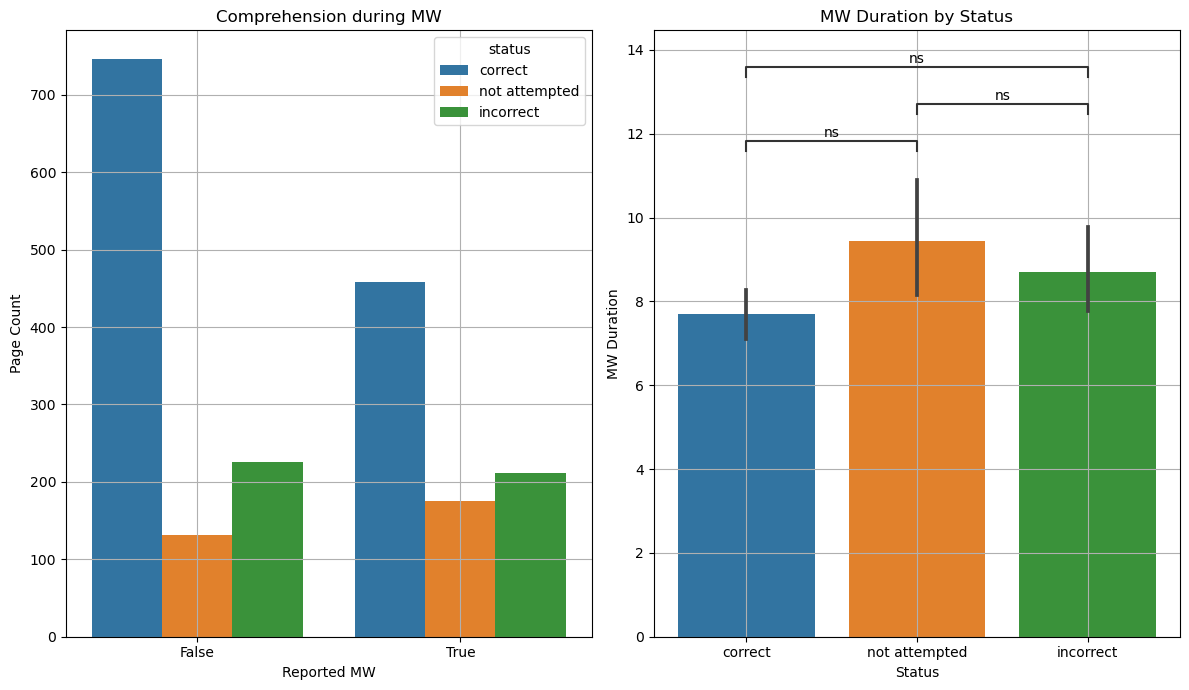

In [21]:
from statannotations.Annotator import Annotator
# Create the subplot layout (1 row, 2 columns)
fig, axes = plt.subplots(1, 2, figsize=(12, 7))

# First subplot: count plot with 'is_MWreported' and 'status'
sns.countplot(data=df, x='is_MWreported', hue='status', ax=axes[0])
axes[0].set_title('Comprehension during MW')
axes[0].set_xlabel('Reported MW')
axes[0].set_ylabel('Page Count')
axes[0].grid(True)

# Second subplot: bar plot with 'status' and 'MW_dur'
sns.barplot(data=df, y='MW_dur', x='status', ax=axes[1])
axes[1].set_title('MW Duration by Status')
axes[1].set_xlabel('Status')
axes[1].set_ylabel('MW Duration')
axes[1].grid(True)

# Define pairs for comparison
pairs = [
    ('correct', 'incorrect'),
    ('correct', 'not attempted'),
    ('incorrect', 'not attempted')
]

# Add statannotations
annotator = Annotator(axes[1], pairs, data=df, x='status', y='MW_dur')
annotator.configure(
    test='Mann-Whitney',
    text_format='star',
    loc='inside'
)
annotator.apply_and_annotate()

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()




# Parse reading info

In [6]:
import os
import pandas as pd

# load eye feature file
path = r"/Volumes/GBLDrive/MindlessReading/Data/Files"
file = "group_features_default_sr.csv"
df = pd.read_csv(os.path.join(path, file))

# define new dataframe for reading information
df_reading = pd.DataFrame()
for col in ['sub_id', 'run', 'reading', 'page', 'page_start', 'page_end', 'is_MWreported', 'mw_onset', 'mw_offset']:
    # copy info to df_reading
    df_reading[col] = df[col]

# compute time duration
df_reading['page_dur'] = df_reading['page_end'] - df_reading['page_start']
df_reading['mw_dur'] = df_reading['mw_offset'] - df_reading['mw_onset']
df_reading['onset2page_end'] = df_reading['page_end'] - df_reading['mw_onset']
df_reading['page_start2onset'] = df_reading['mw_onset'] - df_reading['page_start']
df_reading['offset2page_end'] = df_reading['page_end'] - df_reading['mw_offset']

import itertools

# Expected set of all (run, page) pairs
expected_pairs = set(itertools.product(range(1, 6), range(10)))

# Group by subject and check for missing run-page pairs
missing_info = []

for sub_id, group in df_reading.groupby('sub_id'):
    actual_pairs = set(zip(group['run'], group['page']))
    missing_pairs = expected_pairs - actual_pairs
    if missing_pairs:
        missing_info.append({
            'sub_id': sub_id,
            'missing_count': len(missing_pairs),
            'missing_pairs': sorted(missing_pairs)
        })

# Convert to DataFrame
df_missing = pd.DataFrame(missing_info)

# Display results
print("Subjects missing some (run, page) combinations:")
print(df_missing)

# save dataframe to csv
df_reading.to_csv(os.path.join(path, "reading_time_data.csv"))


Subjects missing some (run, page) combinations:
Empty DataFrame
Columns: []
Index: []


# Histogram of reading time

2399  reading pages
1122  mind-wandering episodes  0.4676948728636932
== Overall Reading Time ==
Mean: 59.179660140955356
Median: 58.031999999999925
Std Dev: 15.13334049159542

== Time Before MW Onset ==
Mean: 22.185758035714304
Median: 19.158500000000004
Std Dev: 17.262096239563114

== MW Duration ==
Mean: 9.44295446428571
Median: 7.005499999999984
Std Dev: 8.308013750459105


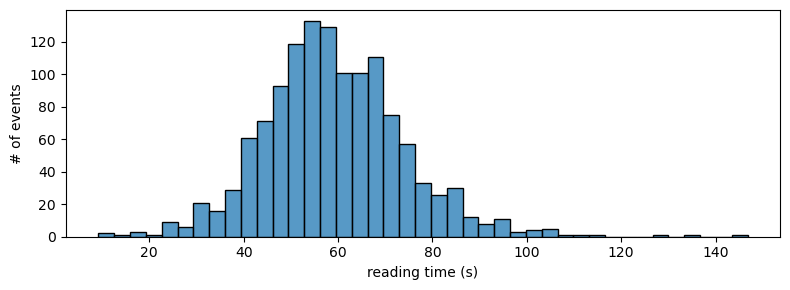

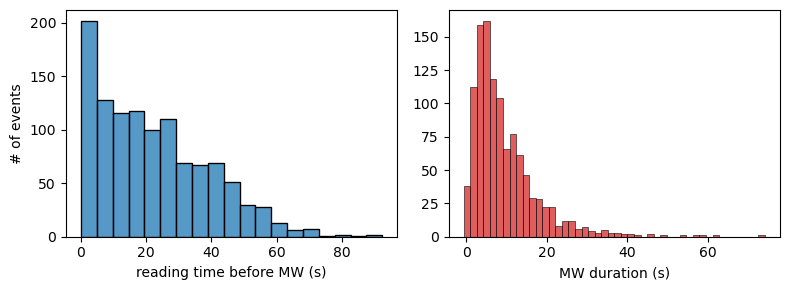

In [ ]:
import os
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

# load eye feature file
path = r"/Volumes/GBLDrive/MindlessReading/Data/Files"
file = "reading_time_data.csv"
df = pd.read_csv(os.path.join(path, file))

path_to_save = r"/Volumes/GBLDrive/MindlessReading/Results/Behavior"

df_nr = df[~df['is_MWreported']]
df_mw = df[df['is_MWreported']]
print(len(df), " reading pages")
print(len(df_mw), " mind-wandering episodes ", len(df_mw)/len(df))

# Stats for page_dur
print("== Overall Reading Time ==")
print("Mean:", df_nr['page_dur'].mean())
print("Median:", df_nr['page_dur'].median())
print("Std Dev:", df_nr['page_dur'].std())

# Stats for time before MW onset
print("\n== Time Before MW Onset ==")
print("Mean:", df_mw['page_start2onset'].mean())
print("Median:", df_mw['page_start2onset'].median())
print("Std Dev:", df_mw['page_start2onset'].std())

# Stats for MW duration
print("\n== MW Duration ==")
print("Mean:", df_mw['onset2page_end'].mean())
print("Median:", df_mw['onset2page_end'].median())
print("Std Dev:", df_mw['onset2page_end'].std())

plt.figure(figsize=(8, 3))
sns.histplot(data=df_nr, x='page_dur', color='tab:blue')
plt.ylabel("# of events")
plt.xlabel("reading time (s)")
ax = plt.gca()  # get current axes
#ax.tick_params(axis='both', direction='in')  # 'in' makes ticks point inside
plt.tight_layout()
plt.savefig(os.path.join(path_to_save, 'reading_time_hist.png'))

df_mw = df[df['is_MWreported']]
fig, axs = plt.subplots(1, 2, figsize=(8, 3), sharey=False)

sns.histplot(data=df_mw, x='page_start2onset', color='tab:blue', ax=axs[0])
# axs[0].tick_params(axis='both', direction='in')  # 'in' makes ticks point inside
axs[0].set_xlabel('reading time before MW (s)')
axs[0].set_ylabel('# of events')

sns.histplot(data=df_mw, x='onset2page_end', color='tab:red', ax=axs[1])
# axs[1].tick_params(axis='both', direction='in')  # 'in' makes ticks point inside
axs[1].set_xlabel('MW duration (s)')
axs[1].set_ylabel('')
plt.tight_layout()
plt.savefig(os.path.join(path_to_save, 'mw_duration_hist.png'))

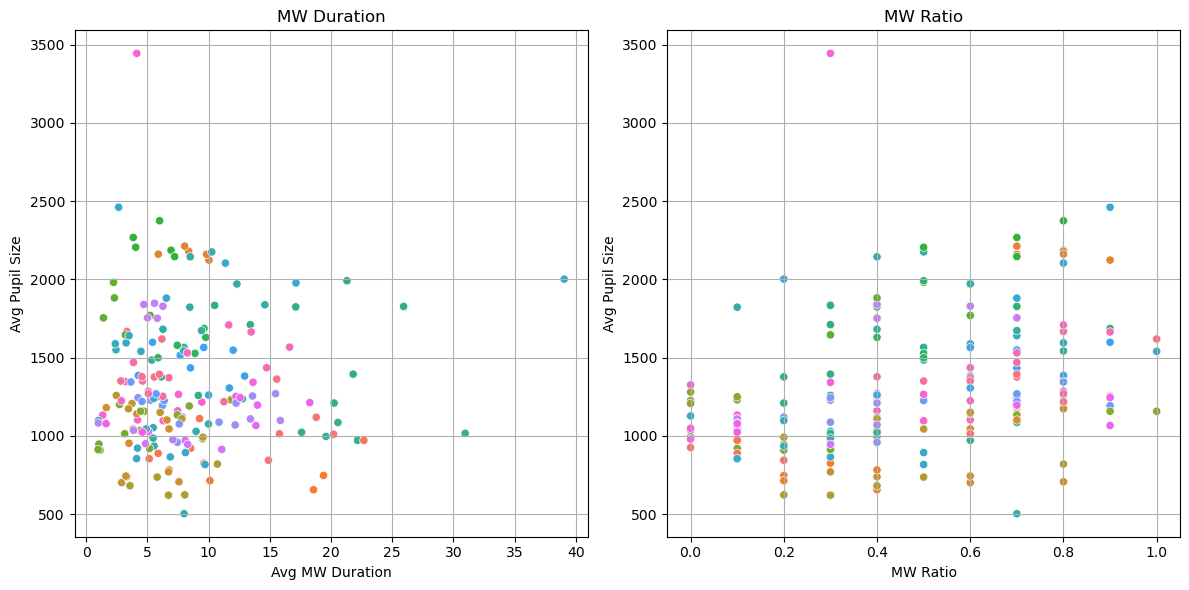

In [40]:
from statannotations.Annotator import Annotator
# Create the subplot layout (1 row, 2 columns)
fig, axes = plt.subplots(1, 2, figsize=(12, 6))


grouped_df = df.groupby(['reading', 'sub_id'], as_index=False)[['pupil_baseline', 'MW_dur']].mean()
sns.scatterplot(data=grouped_df, x='MW_dur', y='pupil_baseline', hue='sub_id', ax=axes[0])
axes[0].legend_.remove()
axes[0].set_title('MW Duration')
axes[0].set_ylabel('Avg Pupil Size')
axes[0].set_xlabel('Avg MW Duration')
axes[0].grid(True)


df['MW_pages'] = df['is_MWreported'].astype(int) 
df['MW_ratio'] = df.groupby(['reading', 'sub_id'])['MW_pages'].transform('sum') / 10 
grouped_df = df.groupby(['reading', 'sub_id'], as_index=False)[['pupil_baseline', 'MW_ratio']].mean() 
sns.scatterplot(data=grouped_df, x='MW_ratio', y='pupil_baseline', hue='sub_id', ax=axes[1])
axes[1].legend_.remove()
axes[1].set_title('MW Ratio')
axes[1].set_ylabel('Avg Pupil Size')
axes[1].set_xlabel('MW Ratio')
axes[1].grid(True)
plt.tight_layout()

# Show the plot
plt.show()

# Individual Mind-wandering information

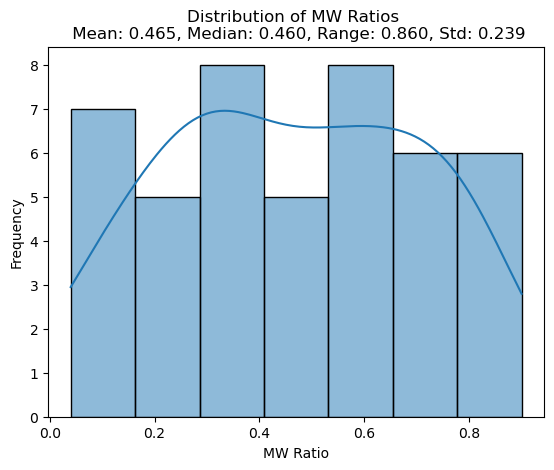

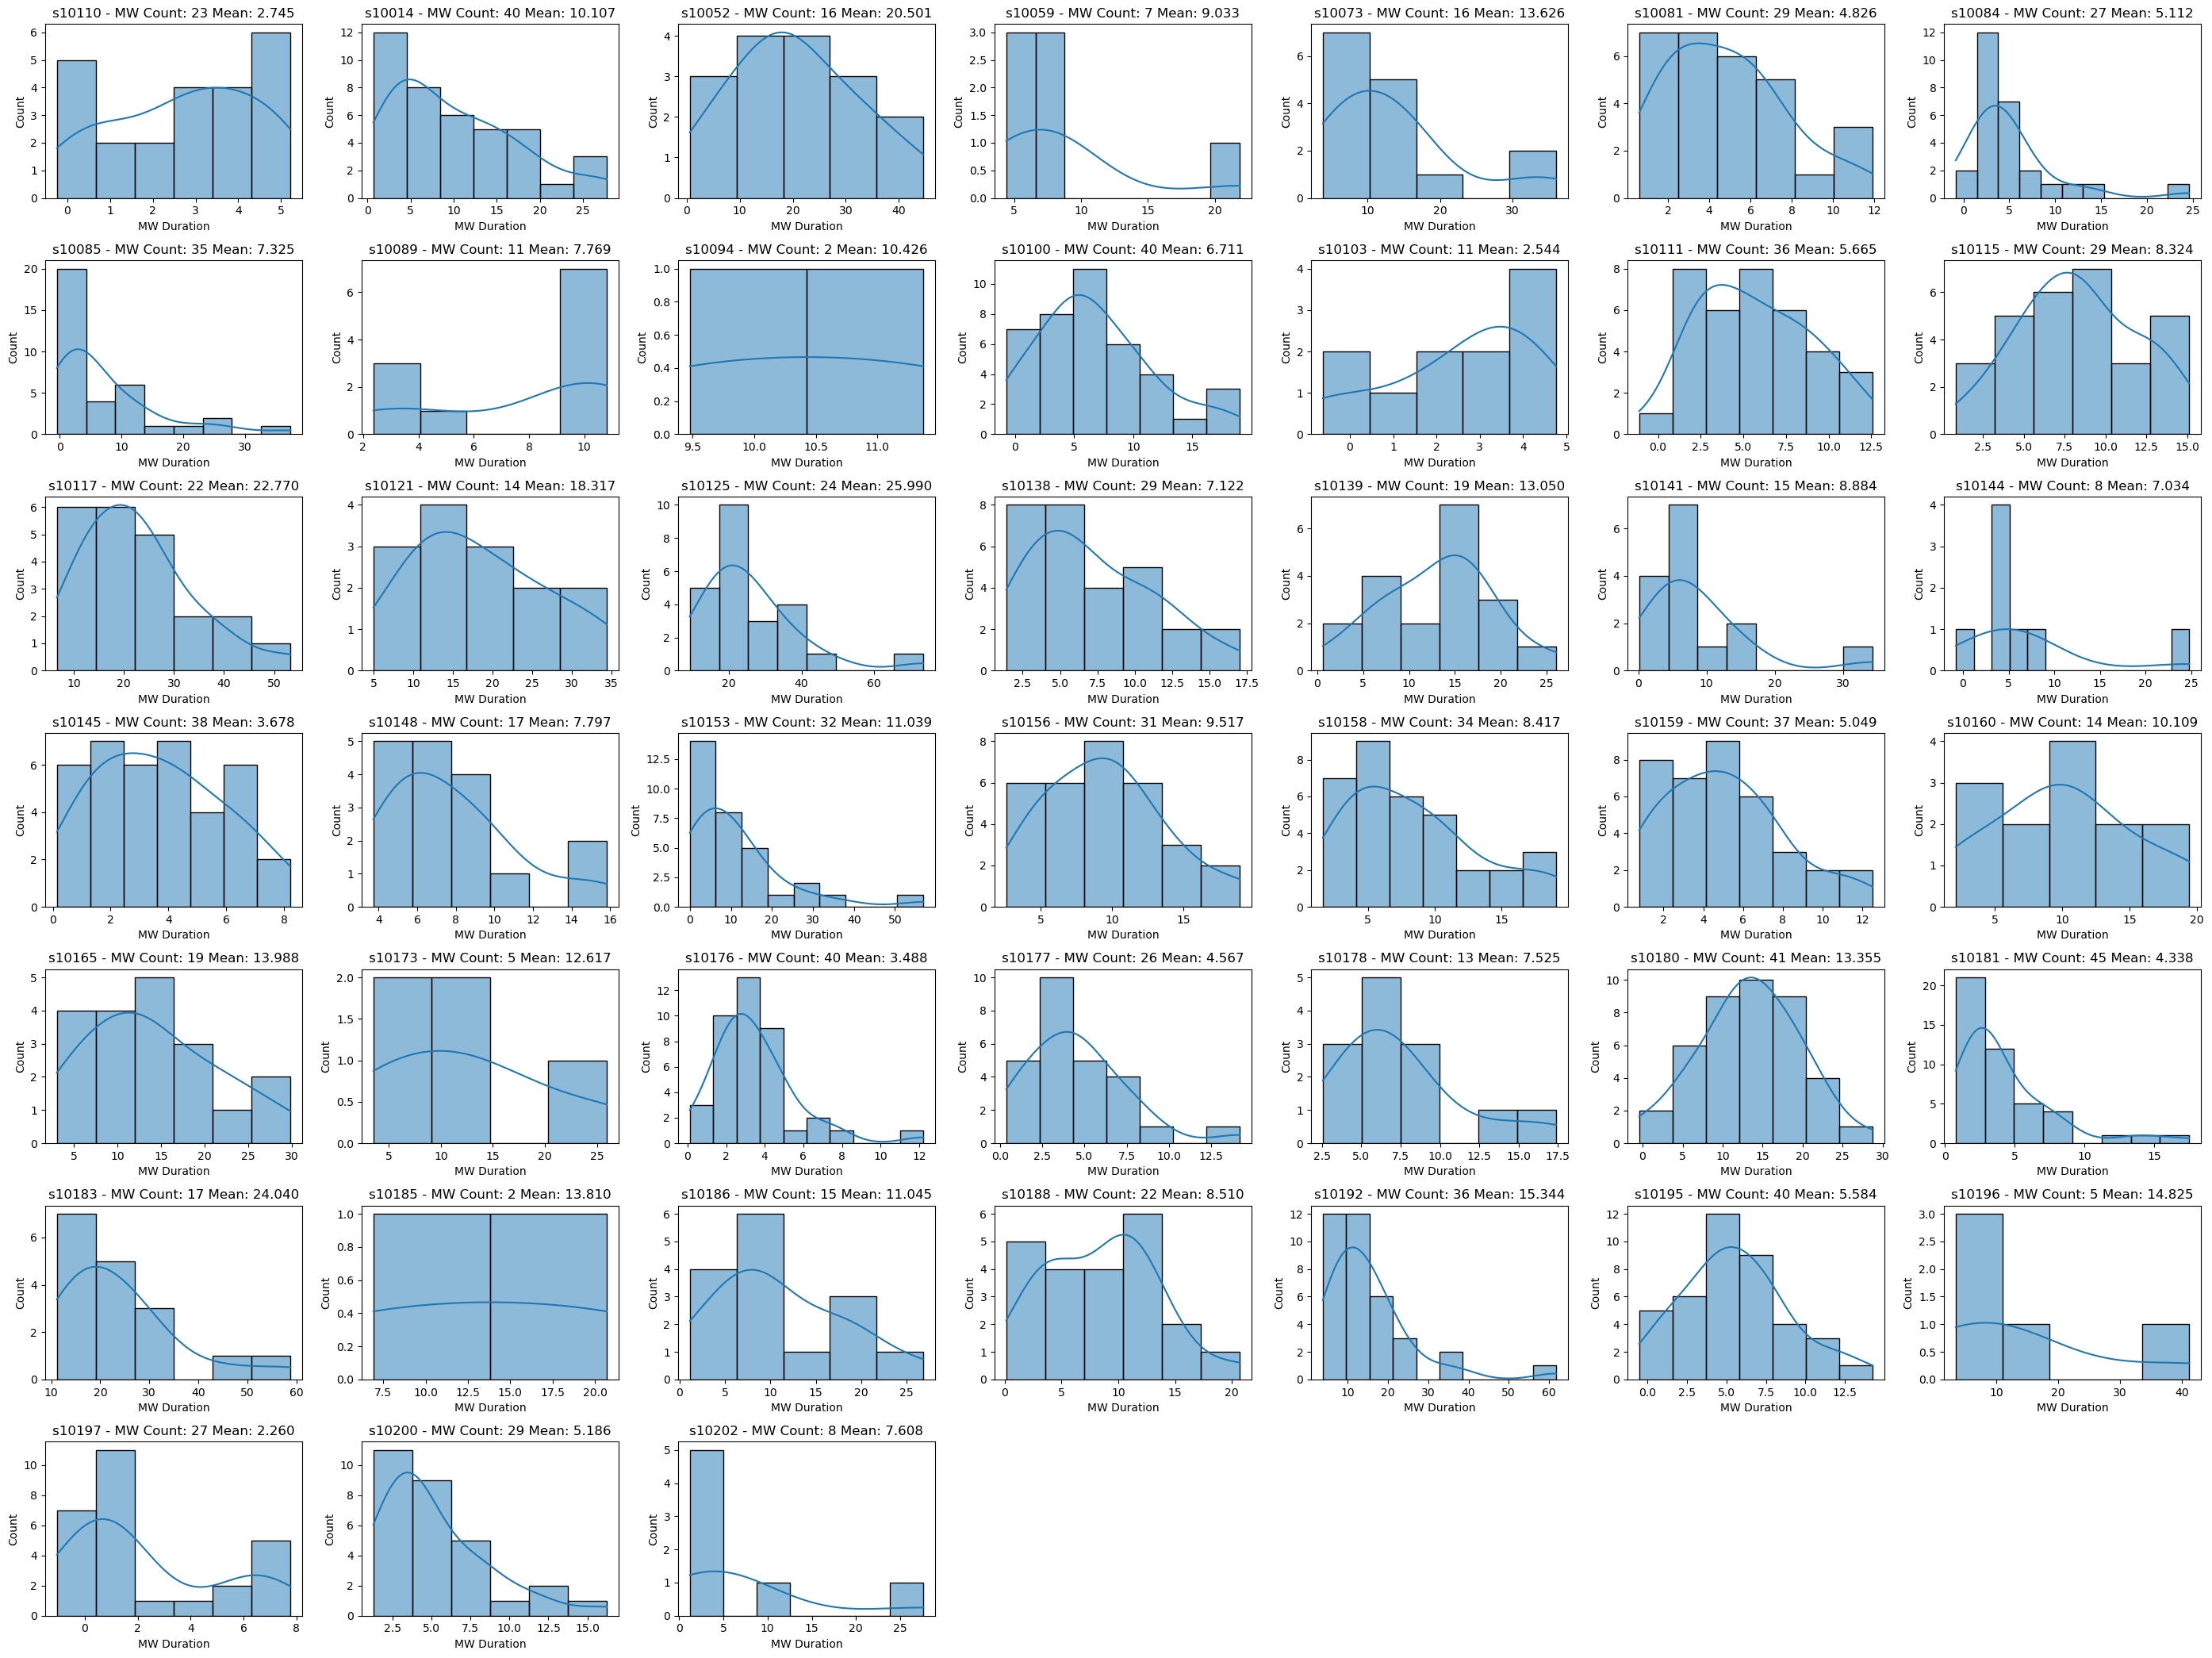

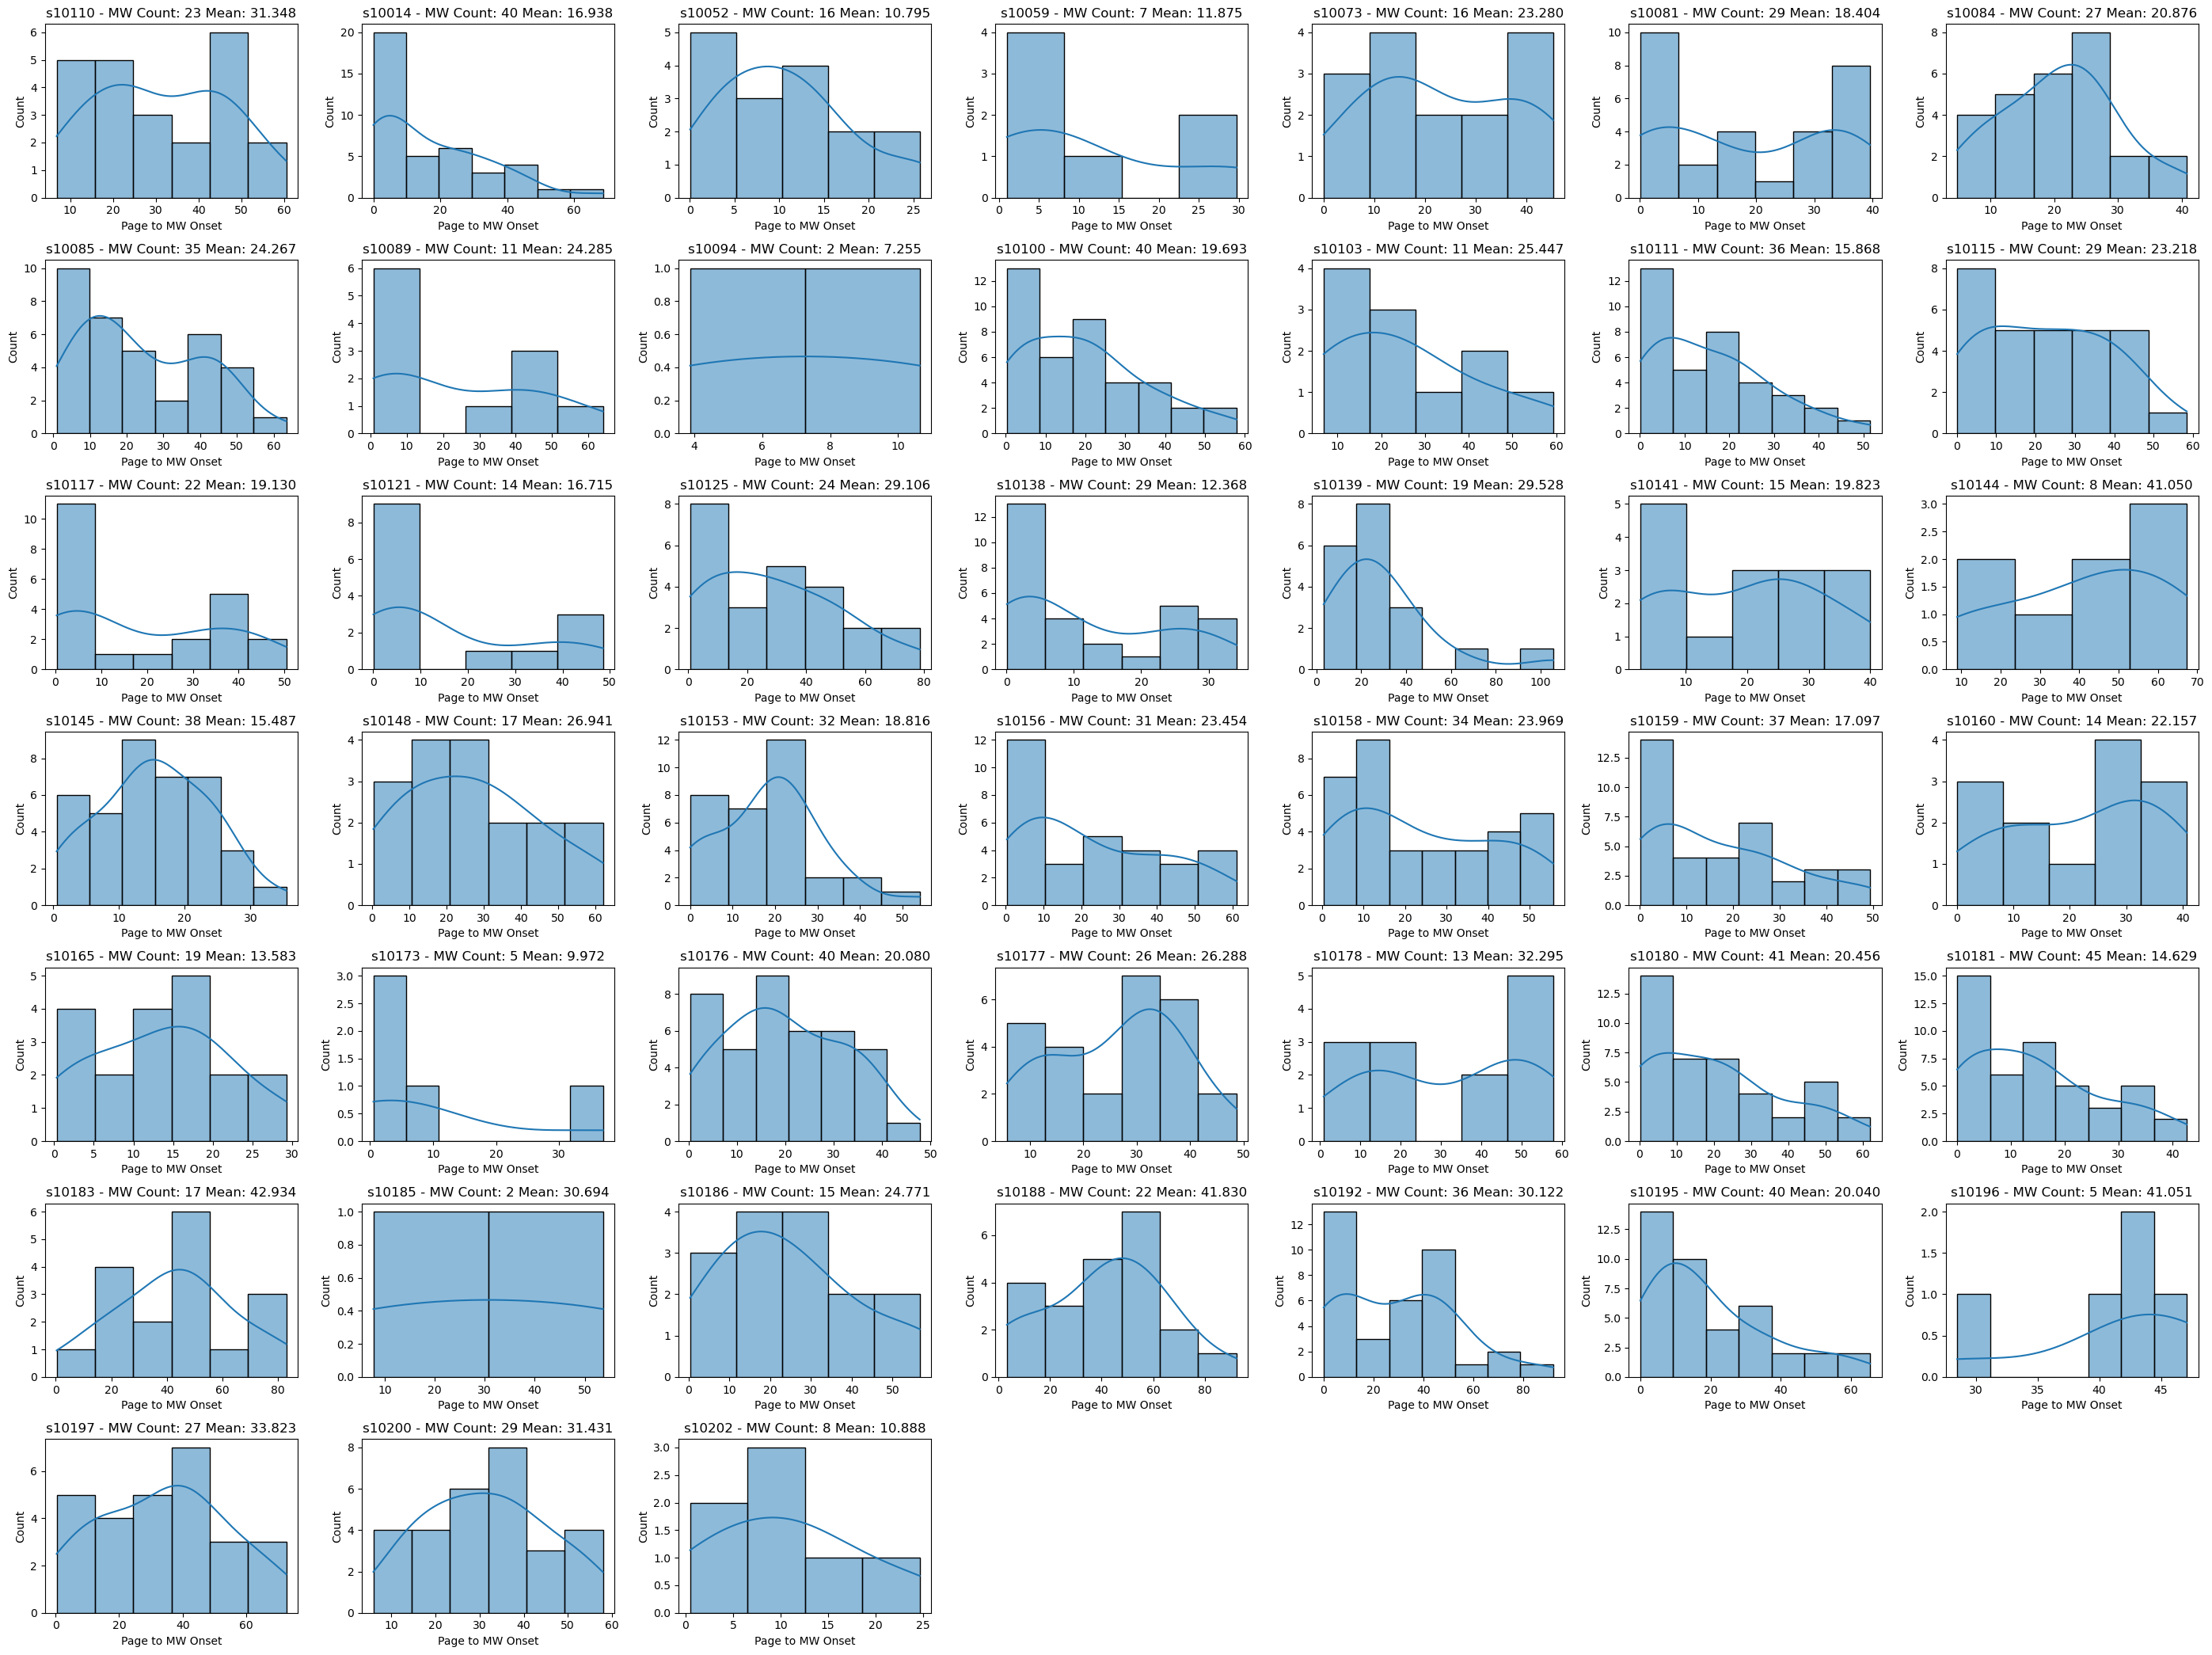

In [9]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

# load eye feature file
path = r"/Volumes/GBLDrive/MindlessReading/Data/Files"
file = "group_features_default_sr.csv"
df = pd.read_csv(os.path.join(path, file))

df_mw = df[df['is_MWreported']].copy()

sub_mw_ratio = []
total_pages = 50
for sub_id in df_mw['sub_id'].unique():
    # Fixed: Use sum() instead of length() to count True values
    mw_pages = (df_mw['sub_id'] == sub_id).sum()
    sub_mw_ratio.append(mw_pages/total_pages)

plt.figure()
sns.histplot(sub_mw_ratio, kde=True)
plt.xlabel('MW Ratio')
plt.ylabel('Frequency')

# Calculate statistics
mean_ratio = np.mean(sub_mw_ratio)
median_ratio = np.median(sub_mw_ratio)
std_ratio = np.std(sub_mw_ratio)
min_ratio = np.min(sub_mw_ratio)
max_ratio = np.max(sub_mw_ratio)
range_ratio = max_ratio - min_ratio

plt.title(f'Distribution of MW Ratios \n Mean: {mean_ratio:.3f}, Median: {median_ratio:.3f}, Range: {range_ratio:.3f}, Std: {std_ratio:.3f}')
plt.show()

df_mw['mw_dur'] = df_mw['page_end'] - 2 - df_mw['mw_onset']
df_mw['page2onset'] = df_mw['mw_onset'] - df_mw['page_start']

# Get unique subjects
subjects = df_mw['sub_id'].unique()
n_subjects = len(subjects)

# Calculate subplot layout (roughly square)
n_cols = int(np.ceil(np.sqrt(n_subjects)))
n_rows = int(np.ceil(n_subjects / n_cols))

# Create figure 1: MW Duration histograms for each subject
fig1, axes1 = plt.subplots(n_rows, n_cols, figsize=(4*n_cols, 3*n_rows))
#fig1.suptitle('MW Duration by Subject', fontsize=16)
axes1 = axes1.flatten() if n_subjects > 1 else [axes1]

for i, sub_id in enumerate(subjects):
    df_sub = df_mw[df_mw['sub_id'] == sub_id]
    if len(df_sub) > 0:
        sns.histplot(df_sub['mw_dur'], ax=axes1[i], kde=True)
        mean_dur = df_sub['mw_dur'].mean()
        axes1[i].set_title(f'{sub_id} - MW Count: {len(df_sub)} Mean: {mean_dur:.3f}')
        axes1[i].set_xlabel('MW Duration')
        axes1[i].set_ylabel('Count')

# Hide empty subplots
for i in range(n_subjects, len(axes1)):
    axes1[i].set_visible(False)

plt.tight_layout()

# Create figure 2: Page-to-Onset histograms for each subject
fig2, axes2 = plt.subplots(n_rows, n_cols, figsize=(4*n_cols, 3*n_rows))
#fig2.suptitle('Page to MW Onset by Subject', fontsize=16)
axes2 = axes2.flatten() if n_subjects > 1 else [axes2]

for i, sub_id in enumerate(subjects):
    df_sub = df_mw[df_mw['sub_id'] == sub_id]
    if len(df_sub) > 0:
        sns.histplot(df_sub['page2onset'], ax=axes2[i], kde=True)
        mean_onset = df_sub['page2onset'].mean()
        axes2[i].set_title(f'{sub_id} - MW Count: {len(df_sub)} Mean: {mean_onset:.3f}')
        axes2[i].set_xlabel('Page to MW Onset')
        axes2[i].set_ylabel('Count')

# Hide empty subplots
for i in range(n_subjects, len(axes2)):
    axes2[i].set_visible(False)

plt.tight_layout()
plt.show()
